## Solubility of Ibuprofen in Supercritical CO2

### Colab Adjustments

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
%cd /content/gdrive/MyDrive/Python_Projects/solubility_in_sc_CO2

/content/gdrive/MyDrive/Python_Projects/solubility_in_sc_CO2


### Importing Packages

In [9]:
! pip install pyrenn

In [10]:
from fugacity_coeff import fugacity_scf
from mixing_parameters import a_mix, a_PRK, alpha, b_mix, b_PRK, a_star, b_star, a_m_cosolvent, a_s_cosolvent, b_m_cosolvent, b_s_cosolvent
from Z_prk import Z_PRK
from P_sat import P_sat
from find_solubility import find_solubility_cosol, find_solubility
from results import write_to_excel
from evaluate_model import AARD, plot_predictions, model_predictions
 

In [11]:
import numpy as np 
import sympy as sp
from sympy import pi
from sympy.abc import i
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from IPython.display import display
from sympy.interactive import init_printing
init_printing(use_latex=True)
from sympy import pprint

### Inputs

#### Temperature and Pressure Inputs

In [12]:
P_num = np.arange(start=100000, stop=17000000, step=100000) # Pa
T_num = 313.15 # in Kelvins
R_num = 8.314 #Pa . m3 . mol-1 . K-1

#### Binary Interaction Parameters

Binary interaction parameters were determined in **'binary_interaction_parameters_ibuprofen.ipynb'**  notebook by the minimization of the **Average absolute relative deviation, AARD(%),** according to the solubility data in <a href= http://www.ijche.com/article_10327_dc073ba6acbffc77feb86f32eb5283f6.pdf>Mirzajanzadeh, Zabihi and Ardjmand's study<a> .

In [13]:
k_num = np.array([[0, 0.14356282,0],[0.14356282,0, 0],[0,0,0]])
l_num = np.array([[0,0.16855572,0],[0.16855572,0,0],[0,0,0]])

#### Ibuprofen Properties

Getting the critical properties of ibuprofen using Joback Method

In [14]:
# from openpyxl import load_workbook, Workbook

# wb1 = load_workbook('ExcelFiles/Joback_Method.xlsx', data_only=True)
# ws1 = wb1.active
# T_c_ibu = ws1['G36'].value # in Kelvin
# P_c_ibu = ws1['G37'].value / 10 # in MPa
# V_c_ibu = ws1['G38'].value # in cm³/mol
# w_ibu = ws1['G40'].value

In [15]:
T_c_ibu = 749.52
P_c_ibu = 2315000
w_ibu = 0.820
v_solid_num = 182.14/10**(6) # m3/mol

In [16]:
P_sub_num = 0.0897

### CO2 Properties

In [17]:
T_c_co2 = 304.25
P_c_co2 = 7377300 # Pa
w_co2 = 0.225

### Calculations

#### Mixing Parameters

In [18]:
alpha_co2 = alpha(w_co2, T_num, T_c_co2)
alpha_ibu = alpha(w_ibu, T_num, T_c_ibu)

a_PRK_CO2 = a_PRK(P_c_co2, T_c_co2, R_num) * alpha_co2
a_PRK_ibu = a_PRK(P_c_ibu, T_c_ibu, R_num) * alpha_ibu

b_PRK_CO2 = b_PRK(P_c_co2, T_c_co2, R_num)
b_PRK_ibu = b_PRK(P_c_ibu, T_c_ibu, R_num)

# print(alpha_co2, alpha_ibu, a_PRK_CO2, a_PRK_ibu, b_PRK_CO2, b_PRK_ibu)

### Calculation of solubility step by step


Calculation of constant a_mix in Van der Vaals mixing rules



  1     1                      
 ___   ___                     
 ╲     ╲                       
  ╲     ╲                      
  ╱     ╱   a[(i, j)]⋅y[i]⋅y[j]
 ╱     ╱                       
 ‾‾‾   ‾‾‾                     
i = 0 j = 0                    

  1      1                                                                    
______ ______                                                                 
╲      ╲                                                                      
 ╲      ╲                                                                     
  ╲      ╲              ⎛⎡                 _____                          ⎤⎞  
   ╲      ╲             ⎜⎢                ╱   2      _______              ⎥⎟  
    ╲      ╲            ⎜⎢(1 - k[0, 0])⋅╲╱  a₁     ╲╱ a₁⋅a₂ ⋅(1 - k[0, 1])⎥⎟  
    ╱      ╱  y[i]⋅y[j]⋅⎜⎢                                                ⎥⎟[i
   ╱      ╱             ⎜⎢                                          _____ ⎥⎟  
  ╱      ╱              ⎜⎢  _______                                ╱   2  ⎥⎟  
 ╱      ╱               ⎝⎣╲╱ a₁⋅a₂ ⋅(1 - k[1, 0])  (1 - k[1, 1])⋅╲╱  a₂   ⎦⎠  
╱      ╱                                                                      
‾‾‾‾‾‾ ‾‾‾‾‾‾                                       

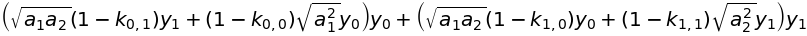


Calculation of constant b_mix in Van der Vaals mixing rules 



  1     1                      
 ___   ___                     
 ╲     ╲                       
  ╲     ╲                      
  ╱     ╱   b[(i, j)]⋅y[i]⋅y[j]
 ╱     ╱                       
 ‾‾‾   ‾‾‾                     
i = 0 j = 0                    

  1     1                                                                     
 ____  ____                                                                   
 ╲     ╲                                                                      
  ╲     ╲                                                                     
   ╲     ╲            ⎛⎡  2⋅b₁⋅(0.5 - 0.5⋅l[0, 0])     (0.5 - 0.5⋅l[0, 1])⋅(b₁
   ╱     ╱  y[i]⋅y[j]⋅⎜⎢                                                      
  ╱     ╱             ⎝⎣(0.5 - 0.5⋅l[1, 0])⋅(b₁ + b₂)    2⋅b₂⋅(0.5 - 0.5⋅l[1, 
 ╱     ╱                                                                      
 ‾‾‾‾  ‾‾‾‾                                                                   
i = 0 j = 0                                                                   

              
              
              
              
 + b₂)⎤⎞      
      ⎥⎟[i, j]
1])   ⎦⎠      
              
              
              

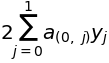

    1                                                                 
   ____                                                               
   ╲                                                                  
    ╲                                                                 
     ╲       ⎛⎡                 _____                         ⎤⎞      
2⋅   ╱  y[j]⋅⎜⎢                ╱   2     _______              ⎥⎟[0, j]
    ╱        ⎝⎣(1 - k[0, 0])⋅╲╱  a₁    ╲╱ a₁⋅a₂ ⋅(1 - k[0, 1])⎦⎠      
   ╱                                                                  
   ‾‾‾‾                                                               
  j = 0                                                               

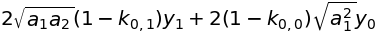

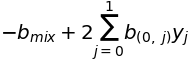

            1                                                                 
           ___                                                                
           ╲                                                                  
            ╲                                                                 
-bₘᵢₓ + 2⋅  ╱   y[j]⋅([2⋅b₁⋅(0.5 - 0.5⋅l[0, 0])  (0.5 - 0.5⋅l[0, 1])⋅(b₁ + b₂)
           ╱                                                                  
           ‾‾‾                                                                
          j = 0                                                               

        
        
        
        
])[0, j]
        
        
        


Calculation of the fugacity of the component in supercritical phase



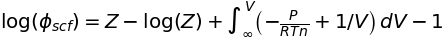

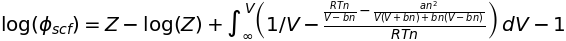

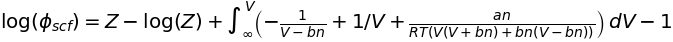

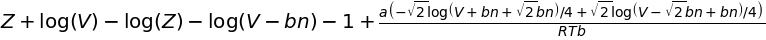

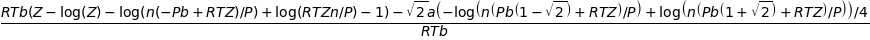

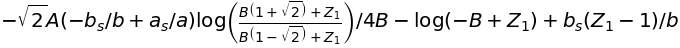

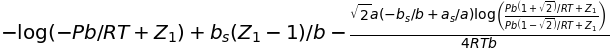


Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 444489.66714631923 
Poynting Correction: 2.4829951026480535
Fugacity: 5.586170582072697e-06
Z= 0.30903539126389107
Calculated Solubility: 0.003066978703309603

Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 477915.0651044853 
Poynting Correction: 2.4829951026480535
Fugacity: 5.195473597605053e-06
Z= 0.3076237505872765
Calculated Solubility: 0.003297613949220949

Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 489436.8422785335 
Poynting Correction: 2.4829951026480535
Fugacity: 5.073167543106627e-06
Z= 0.30716815410285975
Calculated Solubility: 0.0033771142117218814

Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 493458.07901706564 
Poynting Correction: 2.4829951026480535
Fugacity: 5.0318258191131615e-06
Z= 0.3070125986877204
Calculated Solubility: 0.003404860745217753

Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 494867.56971786794 
Poynting Correction: 2.4829951026480535
Fugacity: 5.0174940824343155e-06
Z= 0.3069584864083576
Calculated Solubility: 0.0034145862310532888

Calculation of the solubility of the component in supercritical phase 
 


Enhancement Factor: 495362.35300817667 
Poynting Correction: 2.4829951026480535
Fugacity: 5.012482453641503e-06
Z= 0.3069395412115019
Calculated Solubility: 0.003418000235756419


In [19]:
find_solubility(v_solid_num, 13000000, P_sub_num, R_num, T_num, a_PRK_CO2, a_PRK_ibu, b_PRK_CO2, b_PRK_ibu, k_num, l_num, disp=True)

### Average Absolute Relative Deviation, AARD(%)

In [20]:
y_expe = np.array([0.000198, 0.000573, 0.000766, 0.001393, 0.001596, 0.002142, 0.002287, 0.003019, 0.003261])
P_expe = np.array([9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13]) # in MPa

In [21]:
y_calc_num = [find_solubility(v_solid_num, p*10**6, P_sub_num, R_num, T_num, a_PRK_CO2, a_PRK_ibu, b_PRK_CO2, b_PRK_ibu, k_num, l_num) for p in P_expe]

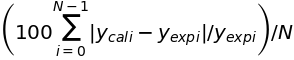

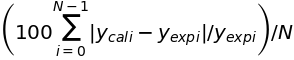

In [22]:
AARD(y_calc_num, y_expe, disp=True)

### Ibuprofen Solubility in scCO2

In [23]:
counter = 0
y_solubility = []
for i in P_num:
    y_final = find_solubility(v_solid_num, i, P_sub_num, R_num, T_num, a_PRK_CO2, a_PRK_ibu, b_PRK_CO2, b_PRK_ibu, k_num, l_num)
    y_solubility.append(y_final)
    counter += 1
    print('%{0}'.format(str(100*counter/len(P_num))))

%0.591715976331361
%1.183431952662722
%1.7751479289940828
%2.366863905325444
%2.9585798816568047
%3.5502958579881656
%4.1420118343195265
%4.733727810650888
%5.325443786982248
%5.9171597633136095
%6.508875739644971
%7.100591715976331
%7.6923076923076925
%8.284023668639053
%8.875739644970414
%9.467455621301776
%10.059171597633137
%10.650887573964496
%11.242603550295858
%11.834319526627219
%12.42603550295858
%13.017751479289942
%13.609467455621301
%14.201183431952662
%14.792899408284024
%15.384615384615385
%15.976331360946746
%16.568047337278106
%17.159763313609467
%17.75147928994083
%18.34319526627219
%18.93491124260355
%19.526627218934912
%20.118343195266274
%20.71005917159763
%21.301775147928993
%21.893491124260354
%22.485207100591715
%23.076923076923077
%23.668639053254438
%24.2603550295858
%24.85207100591716
%25.443786982248522
%26.035502958579883
%26.62721893491124
%27.218934911242602
%27.810650887573964
%28.402366863905325
%28.994082840236686
%29.585798816568047
%30.17751479289941


In [24]:
write_to_excel(P_num, y_solubility,  path='ExcelFiles/y_ibu.xlsx')

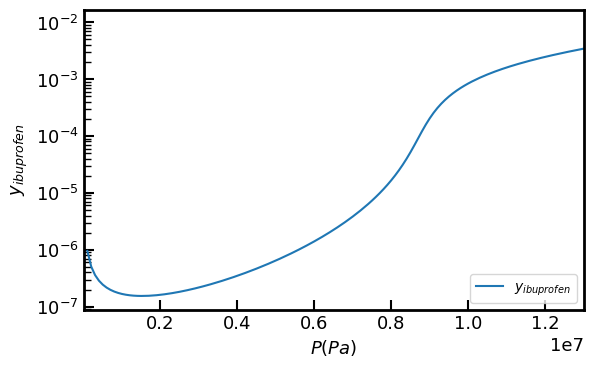

In [27]:
fig = plt.figure(figsize=(5, 3), dpi=100)
mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 2

ax = fig.add_axes([0,0,1,1])
ax.set_xlim(0.1, 13000000)

ax.xaxis.set_tick_params(which='major', size=7, width=1.5, direction='in')
ax.yaxis.set_tick_params(which='major', size=7, width=1.5, direction='in')
ax.yaxis.set_tick_params(which='minor', size=5, width=1, direction='in')

ax.set_xlabel('$P (Pa)$')
ax.set_ylabel('$y_{ibuprofen}$')
ax.set_yscale("log")
ax.plot(P_num, y_solubility, label='$y_{ibuprofen}$', linewidth=1.5)
plt.legend(loc='lower right', prop={'size': 10})
fig.show()